In [124]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt

In [125]:
dict_genres = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, "reggae": 6, "hip hop": 7}
#Lo hice un diccionario pq los modelos necesitan ints, no categorias.
music_df = pd.read_csv('tcc_ceds_music.csv', index_col=False)
music_df = music_df.rename(columns={'len': 'words'}) # es la cantidad de palabras de una "cancion"
music_df = music_df.sort_values(by='release_date', ascending=True)
music_df['genre'] = music_df['genre'].apply(lambda x: dict_genres[x])


In [126]:
train, no_train = np.split(music_df, [int(.80 *len(music_df))])
dev, test =  np.split(no_train, [int(.50 *len(no_train))])


In [127]:
print(len(train) / len(music_df))
print(len(dev) / len(music_df))
print(len(test) / len(music_df))


0.7999788523896799
0.09999295079656
0.10002819681376005


In [128]:
X_train, y_train = train.drop('genre', axis=1), train['genre']
X_no_train, y_no_train = no_train.drop('genre', axis=1), no_train['genre']
X_dev, X_test, y_dev, y_test = train_test_split(X_no_train, y_no_train, train_size=0.9, random_state=42)

In [129]:
X_train.head(50)

,Unnamed: 0,artist_name,track_name,release_date,lyrics,words,dating,violence,world/life,night/time,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
17096,54315,dean martin,be honest with me,1950,honest dear remember dear true wander land hon...,29,0.002392,0.002392,0.002392,0.002392,...,0.220670,0.002392,0.555941,0.635079,0.887550,0.000000,0.924773,0.322301,romantic,1.0
17097,54319,dean martin,three wishes,1950,wish simple wish wish wish days gladness sweet...,29,0.002193,0.002193,0.274582,0.002193,...,0.433883,0.002193,0.281924,0.492270,0.989960,0.000278,0.134378,0.056928,sadness,1.0
17098,54321,dean martin,just for fun,1950,softly sigh close maybe agree hand magic land ...,26,0.003096,0.003096,0.003096,0.003096,...,0.599486,0.003096,0.307917,0.468272,0.964859,0.000457,0.266282,0.109081,sadness,1.0
17099,54324,dean martin,absence makes the heart grow fonder (for someb...,1950,leave know grieve remember absence make heart ...,48,0.001645,0.001645,0.294425,0.001645,...,0.350569,0.182082,0.177949,0.537856,0.936747,0.255061,0.168384,0.122095,sadness,1.0
17100,54329,dean martin,"vieni su (say you love me, too)",1950,vieni vieni vieni come years long wait vieni v...,13,0.114679,0.007519,0.170186,0.594833,...,0.007519,0.007519,0.224521,0.400226,0.976908,0.610324,0.180750,0.040711,night/time,1.0
17101,54330,dean martin,the money song,1950,need need shame funny funny funny money need s...,104,0.000619,0.000619,0.042723,0.000619,...,0.000619,0.000619,0.682660,0.619619,0.945783,0.000000,0.723825,0.250227,obscene,1.0
17102,54332,dean martin,i don't care if the sun don't shine,1950,label vitamin like vitamin alright like vitami...,51,0.166019,0.001196,0.001196,0.198033,...,0.001196,0.054442,0.644753,0.647104,0.930723,0.000334,0.808326,0.315294,romantic,1.0
17103,54336,erroll garner,i don't know why (i just do),1950,weep maverick nigga inadequate girl spend mone...,161,0.000521,0.083346,0.200467,0.000521,...,0.023199,0.055955,0.514784,0.298362,0.995984,0.876518,0.165293,0.048919,obscene,1.0
17104,54340,george shearing,i'll remember april,1950,shear quintet lovely lengthen even sigh goodby...,28,0.002392,0.002392,0.271448,0.002392,...,0.119526,0.002392,0.613343,0.326539,0.991968,0.906883,0.598104,0.114086,romantic,1.0


# Baseline

El género mas frecuente es un baseline simple para este modelo.

In [130]:
train['genre'].value_counts()

1    5864
2    4764
3    3717
4    3193
5    3109
6    1825
7     225
Name: genre, dtype: int64

In [131]:
def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    print(dicc)
    return(dicc)

In [132]:
get_metrics_multi(dev['genre'], [1]*len(dev))

{'f1': 0.0539900351221106, 'precision': 0.03328465683065613, 'acc': 0.2329925978145929, 'recall': 0.14285714285714285}


/home/laureano/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.0539900351221106,
 'precision': 0.03328465683065613,
 'acc': 0.2329925978145929,
 'recall': 0.14285714285714285}

In [133]:
#Podriamos hacer un baseline mas complejo

# Primer modelo

In [134]:
from lib.transformers import FeatureProjection, TargetEncoder, PretrainedFastTextTransformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

features_pipe = make_pipeline(
        FeatureProjection(['words','dating','violence','world/life','night/time','shake the audience',
                            'family/gospel','romantic','communication','obscene','music','movement/places',
                           'light/visual perceptions','family/spiritual','like/girls','sadness','feelings',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy'])
    ,SimpleImputer()
)
   
svc_pipe = make_pipeline(features_pipe, StandardScaler(), SVC(gamma='auto'))

knn_pipe = make_pipeline(
    features_pipe,
    KNeighborsClassifier(n_neighbors=10)
)

In [135]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureprojection',
                                  FeatureProjection(fields=['words', 'dating',
                                                            'violence',
                                                            'world/life',
                                                            'night/time',
                                                            'shake the '
                                                            'audience',
                                                            'family/gospel',
                                                            'romantic',
                                                            'communication',
                                                            'obscene', 'music',
                                                            'movement/places',
                                                            'light/visual '
                                                            'perceptions',
                                                            'family/spiritual',
                                                            'like/girls',
                                                            'sadness',
                                                            'feelings',
                                                            'danceability',
                                                            'loudness',
                                                            'acousticness',
                                                            'instrumentalness',
                                                            'valence',
                                                            'energy'])),
                                 ('simpleimputer', SimpleImputer())])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [136]:
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureprojection',
                                  FeatureProjection(fields=['words', 'dating',
                                                            'violence',
                                                            'world/life',
                                                            'night/time',
                                                            'shake the '
                                                            'audience',
                                                            'family/gospel',
                                                            'romantic',
                                                            'communication',
                                                            'obscene', 'music',
                                                            'movement/places',
                                                            'light/visual '
                                                            'perceptions',
                                                            'family/spiritual',
                                                            'like/girls',
                                                            'sadness',
                                                            'feelings',
                                                            'danceability',
                                                            'loudness',
                                                            'acousticness',
                                                            'instrumentalness',
                                                            'valence',
                                                            'energy'])),
                                 ('simpleimputer', SimpleImputer())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [137]:
pred = knn_pipe.predict(X_dev)

In [138]:
pred2 = svc_pipe.predict(X_dev)

In [139]:
print(pred)

[4 6 6 ... 3 4 5]


In [140]:
print(pred2)

[4 1 4 ... 6 4 5]


In [141]:
get_metrics_multi(y_dev, pred)

{'f1': 0.19740935023481848, 'precision': 0.23949271991174229, 'acc': 0.24006265909535932, 'recall': 0.21251846400791075}


{'f1': 0.19740935023481848,
 'precision': 0.23949271991174229,
 'acc': 0.24006265909535932,
 'recall': 0.21251846400791075}

In [142]:
get_metrics_multi(y_dev, pred2)

{'f1': 0.26293189124618943, 'precision': 0.47785956209571107, 'acc': 0.31505776385353434, 'recall': 0.28003246815688965}


{'f1': 0.26293189124618943,
 'precision': 0.47785956209571107,
 'acc': 0.31505776385353434,
 'recall': 0.28003246815688965}

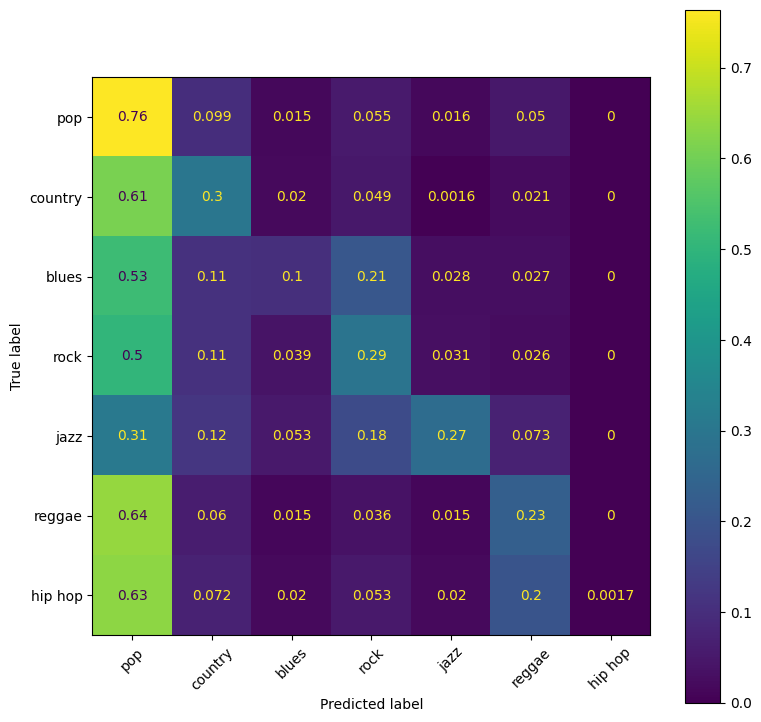

In [143]:
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_dev, pred2, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)

In [144]:
print(list(dict_genres.keys()))

['pop', 'country', 'blues', 'rock', 'jazz', 'reggae', 'hip hop']
